# Optimization 

The goal of this notebook is just to dip your toes into the realm of optimization which is arguably the most important research topic today - all of ML relies on being able to optimize functions ASAP.

# Definitions

Apologies in advance as algorithms cannot be written in nice pseudo-code in native Jupyter, so I have some jank bulleted lists

### Unimodal

A real-valued function $f$ is unimodal on an interval if there is a unique value $x^*$ in the interval such that $f(x^*)$ is the minimum of $f$ on the interval, and $f$ is strictly decreasing for $x\leq x^*$ and strictly increasing for $x^*\leq x$.

### Golden Section Search

*Golden Section Search Algorithm* 

* *Input*: a function $f$, a unimodal interval for $f$: $[a,b]$, and an error tolerance $tol$

* $\tau = \frac{\sqrt{5} - 1}{2}$

* $x_1 = a + (1-\tau)(b-a)$

* $f_1 = f(x_1)$

* $x_2 = a + \tau (b-a)$

* $f_2 = f(x_2)$


* *while* $\left((b - a) > tol\right)$ *do*
    * *if* $(f_1 > f_2)$ *then*
        * $a = x_1$

        * $x_1 = x_2$

        * $f_1 = f_2$

        * $x_2 = a + \tau (b-a)$

        * $f_2 = f(x_2)$
   
    * *else*
        * $b = x_2$

        * $x_2 = x_1$

        * $f_2 = f_1$

        * $x_1 = a + (1-\tau)(b-a)$

        * $f_1 = f(x_1)$

    * *end*
    
* *end*



# Algorithm Implementation

This section is designated to implementing the optimization algorithms and benchmarking performance against datasets. 

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [14]:
# timer class to benchmark running times of algorithms
class Timer: 
    """Record multiple running times"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start timer"""
        self.tik = time.time()

    def stop(self):
        """Stop timer and record the time in a list"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg_time(self):
        """Return average time"""
        return sum(self.times) / len(self.times)

    def sum_time(self):
        """Return sum of time"""
        return sum(self.times)

    def cumsum_time(self):
        """Return accumulated time"""
        return np.array(self.times).cumsum().tolist()

## Golden Section Search

**Note**: Benchmarking this particular algorithm in relation to other ones is not intelligent in the slightest as this algorithm assumes we already are given a unimodal interval - useful only in theory.

In [29]:
def golden_section_search(f, a, b, tol):
    """
    :param: f - function taking a float as input and float as output 
    :param: a - float, specifying min point on the unimodal interval for f
    :param: b - float, specifying max point on the unimodal interval for f
    :param: tol - float, specifying tolerance for how smallest interval to search
    :return: minimum - float, where f is smallest on the interval
    """
    tau = (np.sqrt(5) - 1) / 2
    x_1 = a + (1 - tau) * (b - a)
    f_1 = f(x_1)
    x_2 = a + tau * (b - a)
    f_2 = f(x_2)
    
    while (b - a) > tol:
        if f_1 > f_2:
            a = x_1
            x_1 = x_2
            f_1 = f_2
            x_2 = a + tau * (b - a)
            f_2 = f(x_2)
        else:
            b = x_2
            x_2 = x_1
            f_2 = f_1
            x_1 = a + (1 - tau) * (b - a)
            f_1 = f(x_1)
            
    return f_1

# Example function
def quadratic_func(x):
    return x ** 2

min_point = -10
max_point = 10
tol = 0.1

# Time how long it takes to find min
timer = Timer()
timer.start()
min_est = golden_section_search(f=quadratic_func, a=min_point, b=max_point, tol=tol)
print(f'Estimated Minimum: {min_est:.7f}')
print(f'Time: {timer.stop():.7f} sec')

Estimated Minimum: 0.0000537
Time: 0.0007801 sec


## Examples

### Unimodal Functions

Clearly $y=x^2$ is unimodal over all of $\mathbb{R}$ and we can see that below. A function is unimodal again if there is a unique local minimum for some interval $[a,b]$ - uniqueness of the local minimum can be found by checking if the derivative of the function is zero or not. $y=20$ has derivative zero and we see the minimum is not unique.

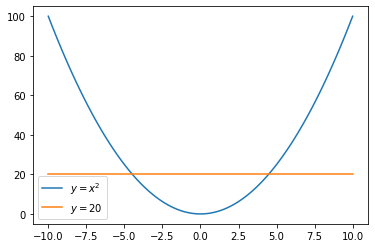

In [6]:
x = np.linspace(-10, 10, 100)
y1 = x ** 2
fig = plt.figure()
ax = plt.axes()
ax.plot(x, y1, label = "$y=x^2$")
ax.plot(x, np.repeat(20, 100), label = "$y=20$"")
ax.legend()

### Golden Section Search Example

Consider the above function $y = x^2$ on the interval $[-10,10]$ where it is unimodal. 

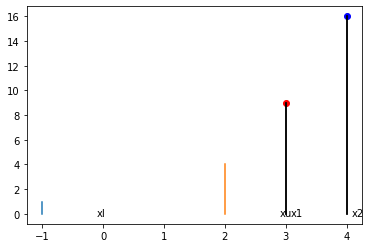

In [42]:
from IPython.display import clear_output

def plot_graph(xl, xu, x1, x2, xlab_shift=0.9):
    clear_output(wait=True)
    
    #plot x1 point
    plt.plot(x1, quadratic_func(x1), 'ro', label='x1')
    plt.plot([x1, x1], [0, quadratic_func(x1)], 'k')
    
    #plot x2 point
    plt.plot(x2, quadratic_func(x2), 'bo', label='x2')
    plt.plot([x2, x2], [0, quadratic_func(x2)], 'k')
    
    #plot xl line
    plt.plot([xl, xl], [0, quadratic_func(xl)])
    plt.annotate('xl', xy=(xl + xlab_shift, -0.2))
        
    #plot xu line
    plt.plot([xu, xu],[0, quadratic_func(xu)])
    plt.annotate('xu',xy=(xu + xlab_shift, -0.2))
        
    #plot x1 line
    plt.plot([x1, x1],[0, quadratic_func(x1)],'k')
    plt.annotate('x1', xy=(x1+0.09,-0.2))
        
    #plot x2 line
    plt.plot([x2, x2],[0, quadratic_func(x2)],'k')
    plt.annotate('x2', xy=(x2+0.09,-0.2))

    
plot_graph(-1, 2, 3, 4)

## Theory Problems

Problems taken Chapter 6 in Heath's book:

**6.1.** True or false: Points that minimize a nonlinear function are inherently less accurately determined than points for which a nonlinear function has a zero value.

- False: I do not like the wording, but I belive by less accurate he means more difficult to find. In this case it makes sense as stationary (zeros) are needed in the process of finding a minimum of a function. That is the latter also requires checking the partials and potentially higher order derivatives to verify if the point is a minimum.

**6.2.** True or false: If a function is unimodal on a closed interval, then it has exactly one minimum on the interval.

- True: By definition, we know that if there were not a unique minimum on the interval then $f$ would not be strictly decreasing and then strictly increasing after the point.

**6.3** True or false: In minimizing a unimodal function of one variable by golden section search, the point discarded at each iteration is always the point having the largest function value.

- True

**6.4** True or false: For minimizing a real-valued function of several variables, the steepest descent method is usually more rapidly convergent than Newton's method.

## Coding Problems

asdf

# Sources

- "Scientific Computing: An Introductory Survey" by Michael Heath.
    - Cool book - used at stanford for graduate ml course, so trust me, it's good.